# Predicción de Exitus (fallecimiento) con Árbol de Decisión

In [14]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 


from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [38]:
# Load the dataset 
X = pd.read_csv("../datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [39]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596,21,0,1,151,Q,1,0
1,4,0.306931,20973,22,0,1,99,Q,1,0
2,4,0.278481,19611,19,0,1,87,Q,1,0
3,3,0.150289,13583,22,0,1,100,Q,1,0
4,1,0.016573,18042,2,0,1,44,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4.

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD.
        
- **edad_dias**: Edad en días del paciente.

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas.
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso.
    
- **proc**: Procedencia del paciente.

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial.

- **tipgrd**: GRD médico (M) o de quirófano (Q).
    
- **tiping**: Tipo de ingreso: Programado, urgente...
    
- **exitus**: 1 = El paciente falleció.

De estas variables, exitus es el target y las 9 variables restantes serán el input de nuestro modelo.

Veamos cuántos casos de exitus tenemos en porcentaje.

In [40]:
100 * np.sum(X['exitus'] == 1) / X.shape[0]

3.8402739558490797

Estamos por tanto, en un caso de problema de clasificación binario con cierto desbalanceo (menos 1s que 0s)

## One-Hot Encoding

Los modelos de logistic regression no admiten variables categóricas, por lo que tendremos que transformarlas a variables numéricas. Para ello utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [41]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [42]:
print(categorical_vars)
print(numerical_vars)

['proc', 'tiping', 'tipgrd', 'gravedad']
['exitus', 'pct_mortalidad_norma', 'edad_dias', 'potencial_ambul', 'numproc', 'estancia_esperada']


Realizamos one hot encoding de las variables categoricas

In [43]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())


Visualizamos los datos iniciales y los que están con one hot encoding para ver la diferencia

In [44]:
X[categorical_vars].head()

,proc,tiping,tipgrd,gravedad
0,1,1,Q,4
1,1,1,Q,4
2,1,1,Q,4
3,1,1,Q,3
4,1,1,Q,1


In [45]:
X_ohe.head()

,"(x0_1,)","(x0_2,)","(x0_3,)","(x0_4,)","(x0_6,)","(x0_7,)","(x0_8,)","(x0_9,)","(x1_1,)","(x1_2,)","(x1_3,)","(x2_M,)","(x2_Q,)","(x3_1,)","(x3_2,)","(x3_3,)","(x3_4,)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Volvemos a pegar las variables numéricas.

In [46]:
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)

Comprobemos que ya no tenemos variables categóricas

In [47]:
X.dtypes

(x0_1,)                 float64
(x0_2,)                 float64
(x0_3,)                 float64
(x0_4,)                 float64
(x0_6,)                 float64
(x0_7,)                 float64
(x0_8,)                 float64
(x0_9,)                 float64
(x1_1,)                 float64
(x1_2,)                 float64
(x1_3,)                 float64
(x2_M,)                 float64
(x2_Q,)                 float64
(x3_1,)                 float64
(x3_2,)                 float64
(x3_3,)                 float64
(x3_4,)                 float64
index                     int64
exitus                    int64
pct_mortalidad_norma    float64
edad_dias                 int64
potencial_ambul           int64
numproc                   int64
estancia_esperada         int64
dtype: object

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [48]:
# Selección del patrón de datos X y del target y
y = X['exitus']
del X['exitus']
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

    (x0_1,)   (x0_2,)   (x0_3,)   (x0_4,)   (x0_6,)   (x0_7,)   (x0_8,)  \
0  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
1  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
2  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
3  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
4  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   

    (x0_9,)   (x1_1,)  (x1_2,)  ...   (x3_1,)   (x3_2,)   (x3_3,)   (x3_4,)  \
0 -0.090724  0.589285  -0.5681  ... -1.322185 -0.435743 -0.417921  4.120705   
1 -0.090724  0.589285  -0.5681  ... -1.322185 -0.435743 -0.417921  4.120705   
2 -0.090724  0.589285  -0.5681  ... -1.322185 -0.435743 -0.417921  4.120705   
3 -0.090724  0.589285  -0.5681  ... -1.322185 -0.435743  2.392797 -0.242677   
4 -0.090724  0.589285  -0.5681  ...  0.756324 -0.435743 -0.417921 -0.242677   

      index  pct_mortalidad_norma  edad_dias  potencial_ambul   numproc  \

## Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [49]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal. 

Es importante indicar aquí que los datos proporcionados ya vienen **ordenados por fecho ingreso**. Si no fuera así, sería necesario realizar este ordenamiento primero para respetar el eje temporal en la división en train, validación y test.

In [50]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [51]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 23)
Train target size = (22894,)
Validation data size = (4905, 23)
Validation target size = (4905,)
Test data size = (4907, 23)
Test target size = (4907,)



## Árbol de Decisión

Vamos a aplicar ahora un modelo de árbol de decisión para intentar predecir la probabilidad de exitus en función de todas las otras variables de las que disponemos en el dataset. Recordemos que la definición de árbol de decisión es la siguiente:

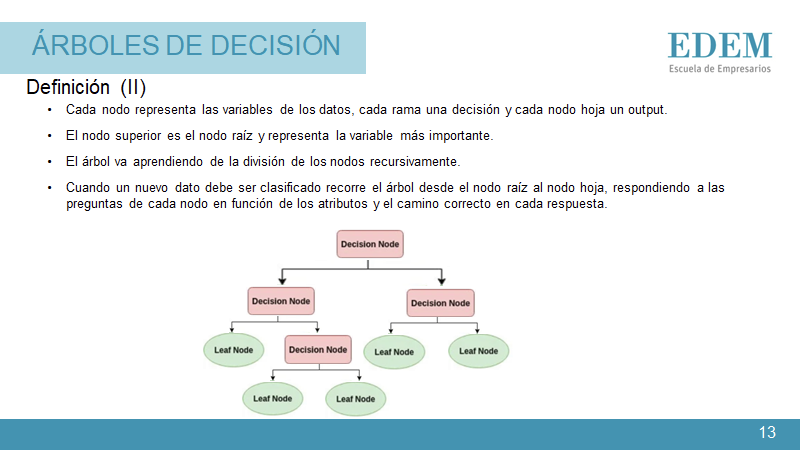


1) Importar modelo.

En este caso DecisionTree


In [52]:
from sklearn.XXX import XXX as model_constructor

Veamos su documentación.

In [53]:
help(model_constructor)

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  

2) Importar métrica.



In [54]:
from sklearn.metrics import XXX as metric

3) Definir el método.



In [55]:
model = XXX

4) Llamar al método fit para entrenar el modelo

In [56]:
XXX

RandomForestClassifier()

5) Llamar al método predict (o predict_proba) para generar las predicciones.

In [60]:
pred_train = XXX
pred_val = XXX
pred_test = XXX

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [63]:
# Calcular métricas de evaluación
metric_train = XXX
metric_val = XXX
metric_test = XXX
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['Tree (Default)'],'metric_train':[metric_train],'metric_val':[auc_val],'metric_test':[metric_test]}, columns=['model',  'metric_train','metric_val', 'metric_test']), ignore_index=True)

In [64]:
results

,model,auc_train,auc_val,auc_test
0,RF,1.0,0.919043,0.923572


También podemos visualizar la curva ROC.

In [65]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

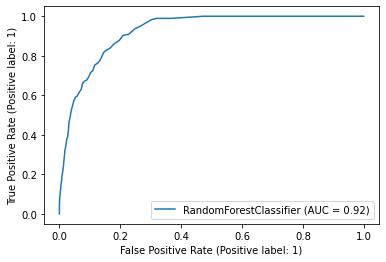

In [66]:
plot_roc_curve(model, X_test, y_test)

# Grid Search

Vamos a proceder a calcular los hiperparámetros óptimos para nuestro modelo. 

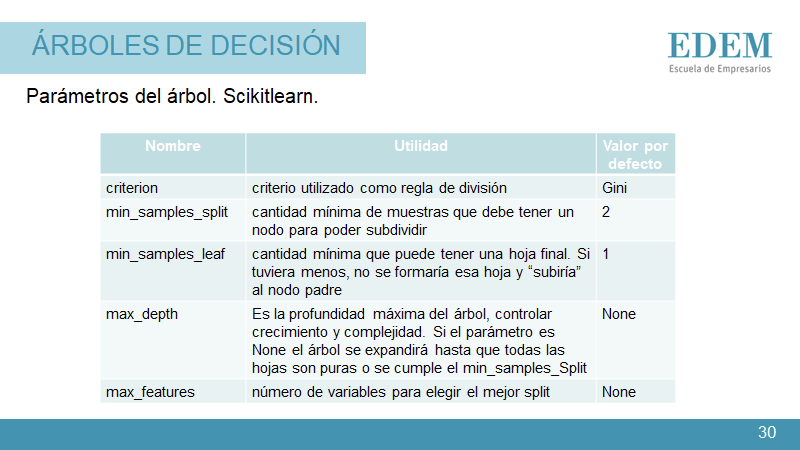

Podemos comprobar los nombres de los hiperparámetros en Scikit-learn.

In [68]:
model?

In [71]:
grid_results = pd.DataFrame();

for n_estimators_v in n_estimators_values:
    # Entrenar modelo
    XXX
    
    # Generar predicciones
    XXX
    
    # Calcular métricas de evaluación
    XXX
    
    grid_results = grid_results.append(pd.DataFrame(data={XXX}), ignore_index=True)


In [72]:
grid_results

,n_estimators,auc_train,auc_val
0,1,0.878410,0.605254
1,5,0.997595,0.800835
2,10,0.999898,0.836987
3,100,1.000000,0.920657


Nos quedamos con el mejor resultado.

In [73]:
best_n_estimators = XXX
best_n_estimators

100

Entrenamos el modelo final, **tras concatenar train y validación**.

In [74]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 23)
Train target size = (22894,)
Validation data size = (4905, 23)
Validation target size = (4905,)
Train data size = (27799, 23)
Train target size = (27799,)


In [75]:
# Entrenar modelo final
XXX
    
# Generar predicciones
XXX
    
# Calcular métricas de evaluación
XXX


results = results.append(pd.DataFrame(data={'model':['Optimized Tree'],'metric_train':[metric_train],'metric_val':[auc_val],'metric_test':[metric_test]}, columns=['model',  'metric_train','metric_val', 'metric_test']), ignore_index=True)
results

,model,auc_train,auc_val,auc_test
0,RF,1.0,0.919043,0.923572
1,RF,1.0,None,0.931286


El mejor modelo entre todos los probados es...

In [76]:
results['model'][results['auc_test'].idxmax()]

'RF'